In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [120]:
def linear_costs(x, y, z, theta):
    costs = (np.matmul(x,theta)-z)*(1-2*y)
    return costs

In [111]:
def paired_classifier(x, costs):
    f_1 = LinearRegression().fit(x, costs)
    return f_1

In [191]:
def obj_grad(objective, x, z, theta, n):
    if objective=='MSE':
        grad = (2/n)*np.matmul(np.transpose(x),np.matmul(x,theta)-z)
        return grad.flatten()
    elif objective=='dot_product':
        grad = (1/n)*np.matmul(np.transpose(x),z)
        return grad.flatten()
    else:
        return 0

In [208]:
def linear_proxies(x, y, z, C, iters, n, objective=None):
    zhat = LinearRegression().fit(x, z)
    theta = [np.transpose(zhat.coef_)]
    grad_l = []
    for t in range(1, iters):
        costs = linear_costs(x, y, z, theta[t-1])
        f_1 = paired_classifier(x, costs)
        h_s = np.hstack((np.zeros(n).reshape(-1,1), f_1.predict(x)))
        h = np.argmin(h_s, axis=1).reshape(-1,1)
        if np.abs(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) >= np.abs(np.matmul(np.transpose(np.matmul(x,theta[t-1])-z),np.abs(h-y)))[0]:
            penalty = np.sign(np.sum(np.matmul(x,theta[t-1]))/np.sum(z) - 1) * np.sum(x, axis=0)/np.sum(z)
        else:
            penalty = -np.sign(np.matmul(np.transpose(np.matmul(x,theta[t-1])-z),np.abs(h-y))) * np.matmul(np.transpose(x),np.abs(h-y))  
            penalty = penalty.flatten()
        grad_l.append(obj_grad(objective,x,z,theta[t-1],n) - C * penalty) 
        theta.append(theta[t-1] - (np.power(t, -1/2) * grad_l[t-1]).reshape(-1,1))
    return theta, grad_l

In [209]:
#np.random.seed(1)
n = 100
intercept = np.ones(n).reshape(-1,1)
x_train = np.transpose(np.random.rand(n,1)).reshape(-1,1)
x_train = np.hstack((intercept, x_train))
y_train = np.round(np.random.rand(n).reshape(-1,1))
z_train = np.round(np.random.rand(n).reshape(-1,1))

coefficients, gradients = linear_proxies(x_train, y_train, z_train, 1, 1000, n, objective='dot_product')

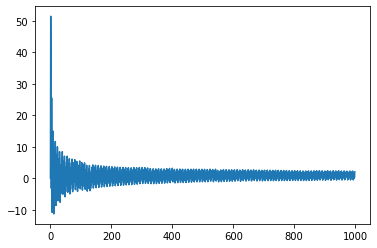

In [210]:
coefficients_0 = [row[0] for row in coefficients]
plt.plot(coefficients_0)

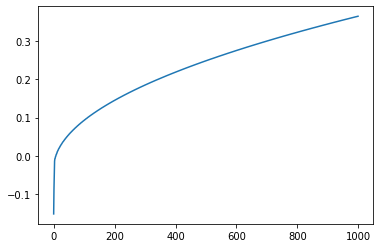

In [206]:
coefficients_1 = [row[1] for row in coefficients]
plt.plot(coefficients_1)

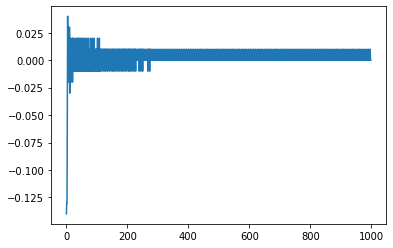

In [207]:
gradients_0 = [row[0] for row in gradients]
plt.plot(gradients_0)

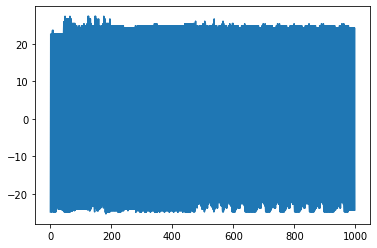

In [202]:
gradients_1 = [row[1] for row in gradients]
plt.plot(gradients_1)